# Spotify Genre Classification
by Krysten Nguyen

## Loading the data

In [210]:
import pandas as pd

data = pd.read_csv('musicData.csv')
print(data.head())

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability  duration_ms  energy  instrumentalness key  \
0       0.00468         0.652         -1.0   0.941           0.79200  A#   
1       0.01270         0.622     218293.0   0.890           0.95000   D   
2       0.00306         0.620     215613.0   0.755           0.01180  G#   
3       0.02540         0.774     166875.0   0.700           0.00253  C#   
4       0.00465         0.638     222369.0   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness               tempo obtained_date  \
0     0.115    -5.2

## Random Seed

In [2]:
import random
SEED = random.seed(15113718)

## 1. Preprocess data

In [211]:
# drop missing rows
data = data.dropna(how='all', axis=0)
print(data.isnull().sum())


instance_id         0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64


- Transform key of the song into numerical data


In [212]:
key_map = {'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5, 'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11}

data['key'].unique()
keys = data['key'].map(key_map)
data['key'] = keys



- Transform categorical variable (mode) into dummy variables


In [213]:
data = pd.concat([data, pd.get_dummies(data['mode'], prefix='mode')], axis=1)
data = data.drop('mode', axis=1)
print(data.columns)


Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
       'tempo', 'obtained_date', 'valence', 'music_genre', 'mode_Major',
       'mode_Minor'],
      dtype='object')


- Transform genre category into numerical labels

In [214]:
genres = data['music_genre'].unique()
genre_map = {genre: i for i, genre in enumerate(genres)}
print(genre_map)
#data['music_genre'] = data['music_genre'].map(genre_map)


{'Electronic': 0, 'Anime': 1, 'Jazz': 2, 'Alternative': 3, 'Country': 4, 'Rap': 5, 'Blues': 6, 'Rock': 7, 'Classical': 8, 'Hip-Hop': 9}


- Missing value imputation
    - durations: '-1.0'
    - tempo: '?'


In [215]:
# impute '?' values in 'tempo' column with KNN
data['tempo'] = data['tempo'].replace('?', None)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
data['tempo'] = imputer.fit_transform(data['tempo'].values.reshape(-1,1))


# impute '-1.0' in 'durations' column with KNN
data['duration_ms'] = data['duration_ms'].replace(-1.0, None)
data['duration_ms'] = imputer.fit_transform(data['duration_ms'].values.reshape(-1,1))


print(data.head())





   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability    duration_ms  energy  instrumentalness  key  \
0       0.00468         0.652  245503.541466   0.941           0.79200   10   
1       0.01270         0.622  218293.000000   0.890           0.95000    2   
2       0.00306         0.620  215613.000000   0.755           0.01180    8   
3       0.02540         0.774  166875.000000   0.700           0.00253    1   
4       0.00465         0.638  222369.000000   0.587           0.90900    6   

   liveness  loudness  speechiness    tempo obtained_date  valence  \
0     0.11

In [216]:
data.dtypes

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
obtained_date        object
valence             float64
music_genre          object
mode_Major             bool
mode_Minor             bool
dtype: object

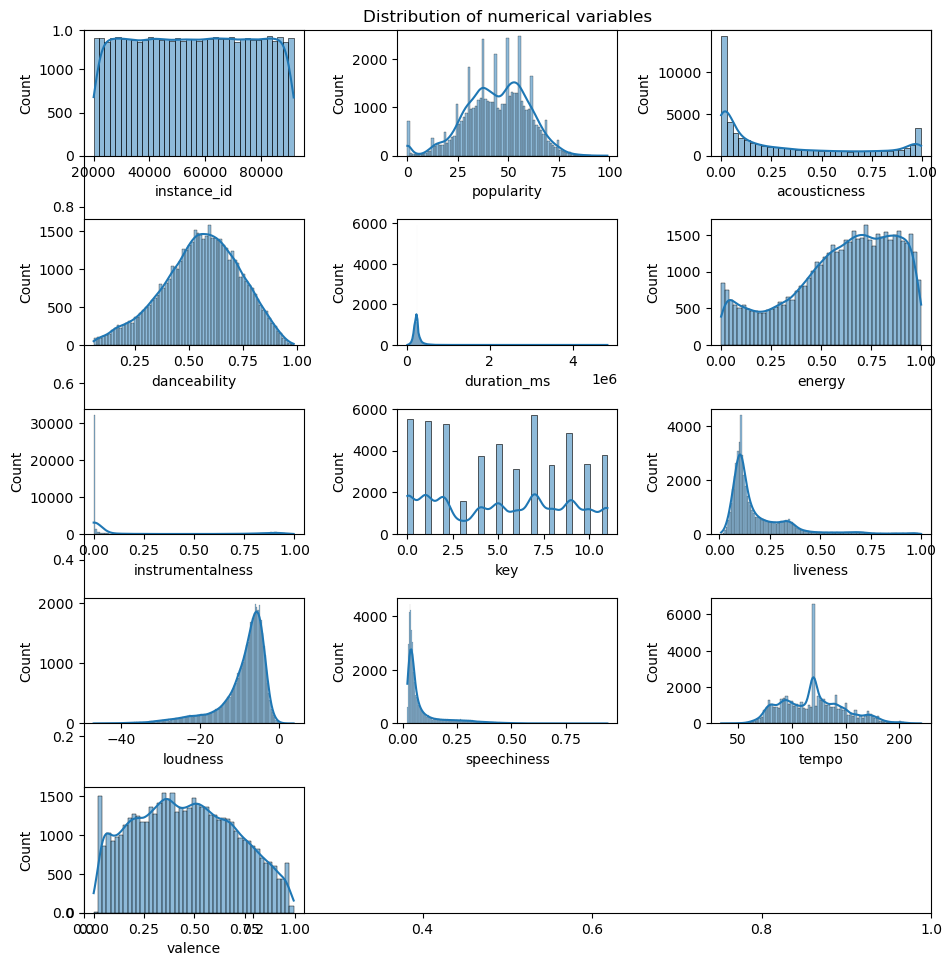

In [217]:
# graph distribution of numerical variables
import matplotlib.pyplot as plt
import seaborn as sns

# numerical variables
numerical = data.select_dtypes(include=['int64', 'float64'])
fig = plt.figure(figsize=(10, 10))
plt.title('Distribution of numerical variables')
for i in range(len(numerical.columns)):
    fig.add_subplot(5, 3, i+1)
    sns.histplot(numerical[numerical.columns[i]], kde=True)
    plt.xlabel(numerical.columns[i])
plt.tight_layout()
plt.show()


- Normalize acousticness and instrumentalist with log transformation

In [273]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler


acoustic = data['acousticness']
acoustic = np.log(acoustic+1)
data['acousticness'] = acoustic


instrumental = data['instrumentalness']
instrumental = np.log(instrumental+1)
data['instrumentalness'] = instrumental



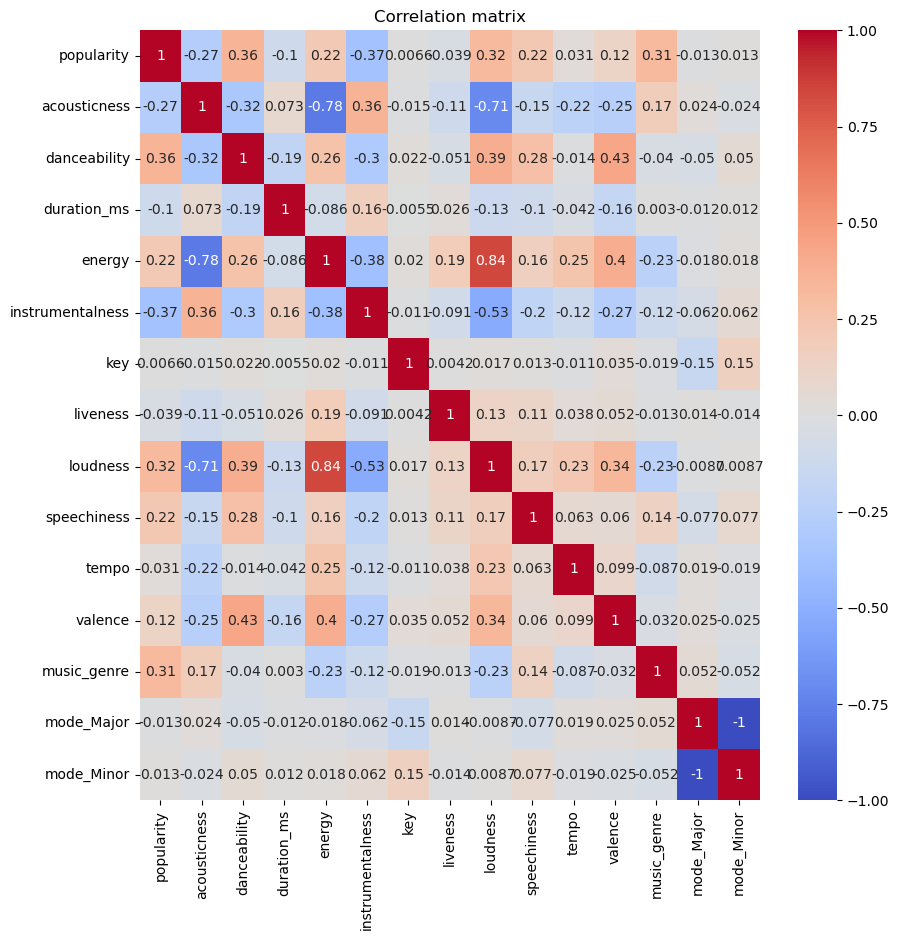

In [ ]:
linguistic_var = ['artist_name', 'track_name', 'instance_id', 'obtained_date'] # linguistic variables to drop
# heatmap of correlation matrix
numerical_data = data.drop(linguistic_var, axis=1)
corr = numerical_data.corr()
fig = plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


Energy and loudness is correlated, which is logical. Acousticness is inversely correlated to energy and loudness a lesser degree. 

## 2. Scale data


- Scale the numerical variables

In [ ]:
data.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
       'tempo', 'obtained_date', 'valence', 'music_genre', 'mode_Major',
       'mode_Minor'],
      dtype='object')

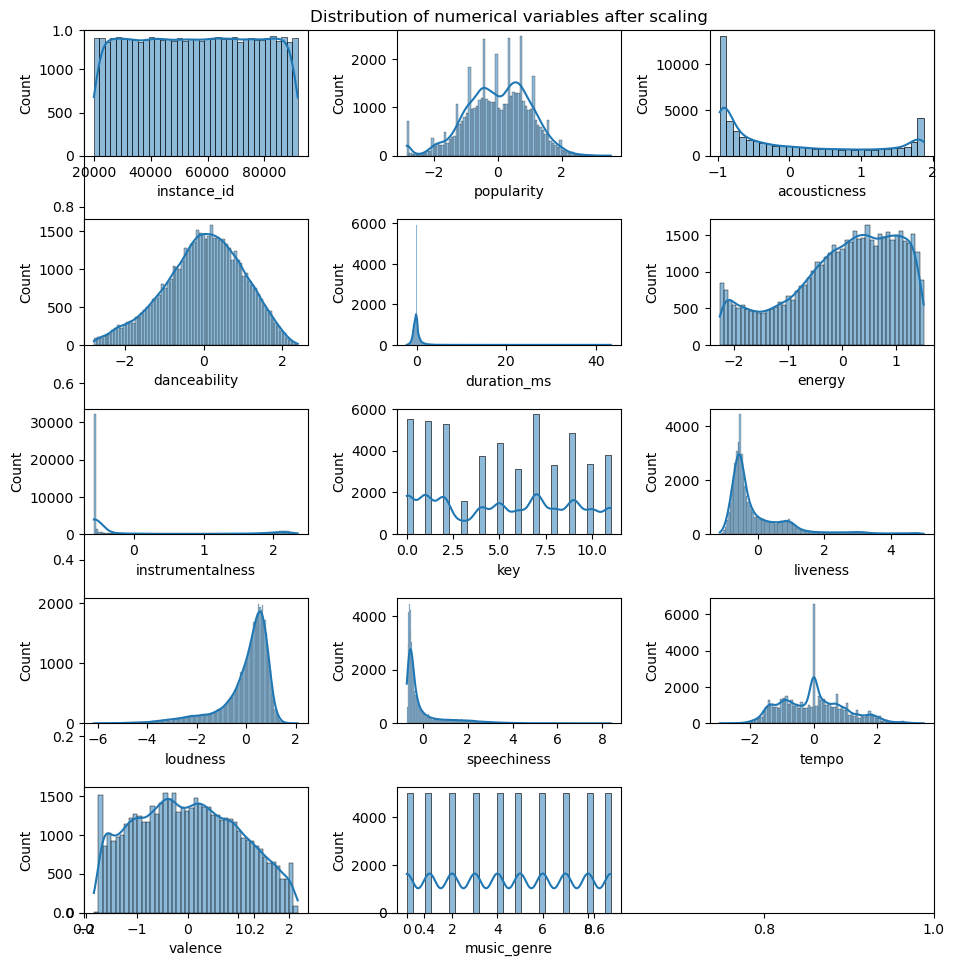

In [ ]:
# scale numerical variables
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
vars_to_scale = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence']

for var in vars_to_scale:
    data[var] = scaler.fit_transform(data[var].values.reshape(-1,1))


# numerical variables
numerical = data.select_dtypes(include=['int64', 'float64'])
fig = plt.figure(figsize=(10, 10))
plt.title('Distribution of numerical variables after scaling')
for i in range(len(numerical.columns)):
    fig.add_subplot(5, 3, i+1)
    sns.histplot(numerical[numerical.columns[i]], kde=True)
    plt.xlabel(numerical.columns[i])
plt.tight_layout()

plt.show()


In [ ]:
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,obtained_date,valence,music_genre,mode_Major,mode_Minor
0,32894.0,Röyksopp,Röyksopp's Night Out,-1.108003,-0.954668,0.524878,2.751216e-16,1.289876,1.892942,10,-0.488113,0.638132,-0.185322,-0.655673,4-Apr,1.225073,0,False,True
1,46652.0,Thievery Corporation,The Shining Path,-0.850633,-0.921902,0.356933,-2.572242e-01,1.097101,2.250392,2,-0.432433,0.339248,-0.627258,-0.170280,4-Apr,0.302431,0,False,True
2,30097.0,Dillon Francis,Hurricane,-1.043661,-0.961319,0.345737,-2.825585e-01,0.586813,-0.525121,8,2.104140,0.732892,-0.582867,0.276558,4-Apr,-0.498812,0,True,False
3,62177.0,Dubloadz,Nitro,-0.657606,-0.870541,1.207853,-7.432841e-01,0.378918,-0.564057,1,-0.228269,0.752201,1.434452,0.277246,4-Apr,-0.753752,0,True,False
4,24907.0,What So Not,Divide & Conquer,-0.786291,-0.954792,0.446504,-2.186933e-01,-0.048212,2.160498,6,-0.228269,0.465324,-0.515787,0.862689,4-Apr,-0.539278,0,True,False


## 3. Split training - test set

Specs: For *each* genre, use 500 randomly picked songs for the test set and the other 4500 songs from that genre for the training set. So the complete test set will be 5000x1 randomly picked genres (one per song, 500 from each genre). Use all the other data in the training set and make sure there is no leakage.


In [ ]:
# keep track of remaining data, test data and training data
remaining_data = data.copy()
test_set = pd.DataFrame()
training_set = pd.DataFrame()

# there are 10 genres consider
for genre in range(10):
    genre_data = remaining_data[remaining_data['music_genre'] == genre]
    # randomly picked 500 songs and add to test_set
    test = genre_data.sample(n=500, random_state=SEED)
    test_set = pd.concat([test_set, test])
   
    # remove test data from dataset and genre_data
    genre_data = genre_data.drop(test.index)
    remaining_data = remaining_data.drop(test.index)

    # randomly picked 4500 songs into training_set
    train = genre_data.sample(n=4500, random_state=SEED)
    training_set = pd.concat([training_set, train])
    # remove training data from dataset
    remaining_data = remaining_data.drop(train.index)





In [ ]:
X_train = training_set.drop(linguistic_var + ['music_genre'], axis=1)
y_train = training_set['music_genre']

X_test = test_set.drop(linguistic_var + ['music_genre'], axis=1)
y_test = test_set['music_genre']


In [ ]:
# check shape
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(45000, 14) (45000,)
(5000, 14) (5000,)


## 4. Dimensionality Reduction and Clustering

Because the dataset has labels, I first attempt to perform supervised dimensionality reduction with Linear Discriminant Analysis(LDA. I will also perform PCA for comparison. Manifold and embedding methods are not necessary because we wish to preserve the distance in the dataset for furture classification models.

In [ ]:
# retrieve from pickle
import pickle
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
    

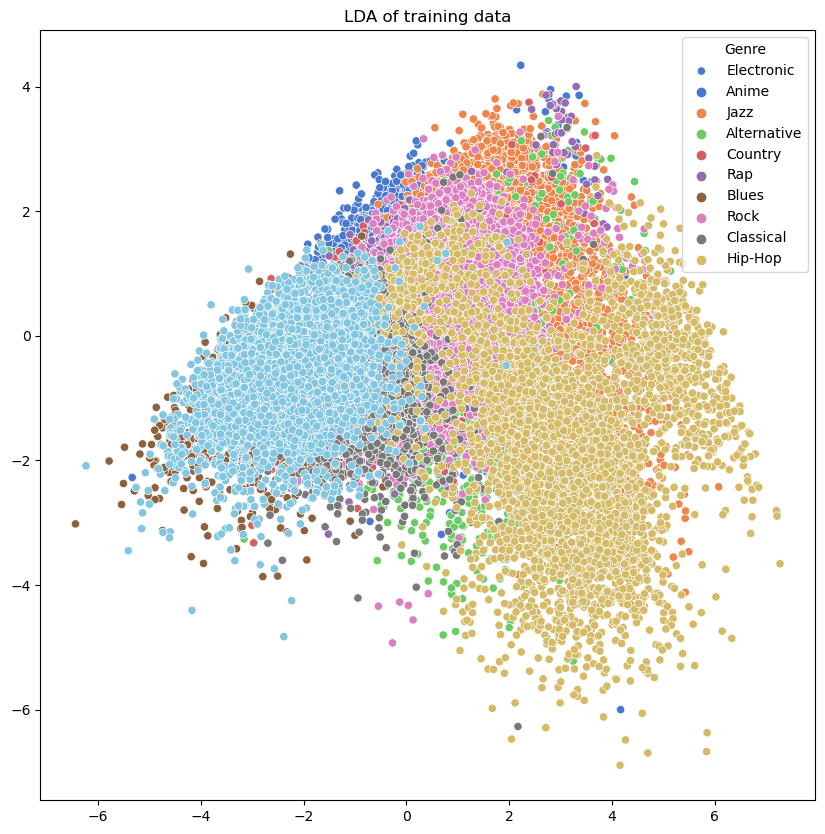

In [219]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt
import seaborn as sns
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

data_lda = lda.transform(X_train)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_lda[:,0], y=data_lda[:,1], hue=y_train, palette='muted')
plt.legend(title='Genre', loc='upper right', labels=[genre for genre in genre_map])
plt.title('LDA of training data')
plt.show()


In [252]:
# explained  variance in 2 dimension
lda.explained_variance_ratio_[:2].sum()



0.8095391187734007

/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


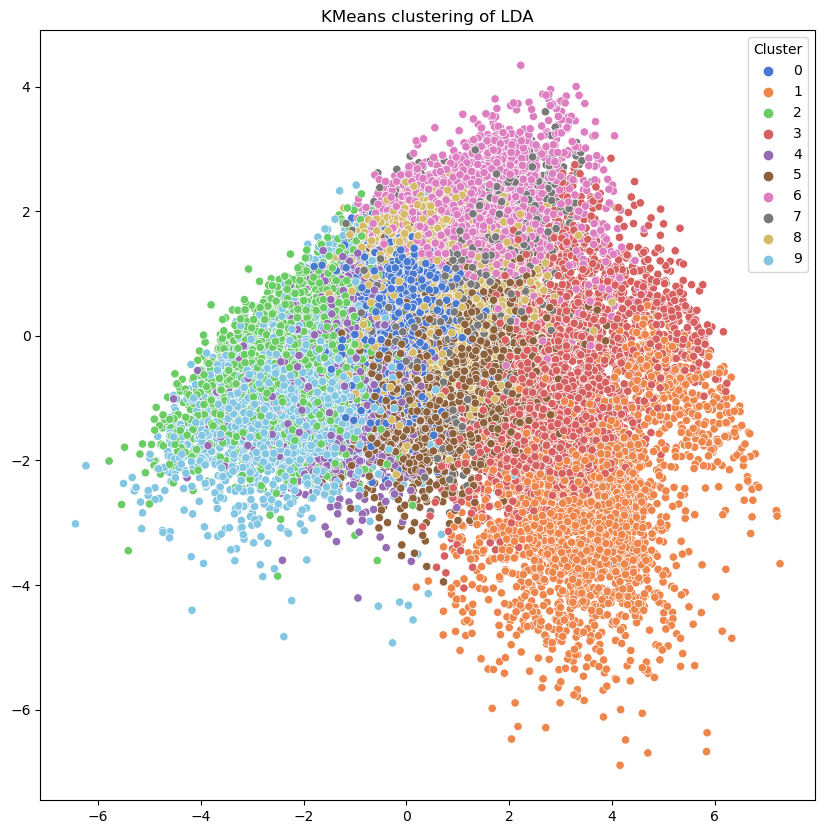

In [220]:
# kmeans clustering with LDA
from sklearn.cluster import KMeans
# k = 10 because there are 10 genres
kmeans = KMeans(n_clusters=10, random_state=SEED)

kmeans.fit(data_lda)
clusters = kmeans.predict(data_lda)
plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_lda[:,0], y=data_lda[:,1], hue=clusters, palette='muted')
plt.legend(title='Cluster', loc='upper right')
plt.title('KMeans clustering of LDA')
plt.show()


LDA result does not distinctly separate different genres. 


[5.25804217e-01 1.51919598e-01 5.61303987e-02 4.36105747e-02
 4.05810880e-02 3.92482675e-02 3.42365349e-02 3.09129938e-02
 2.49862510e-02 1.90201686e-02 1.77630151e-02 1.12484112e-02
 4.53848138e-03 2.68786308e-31]


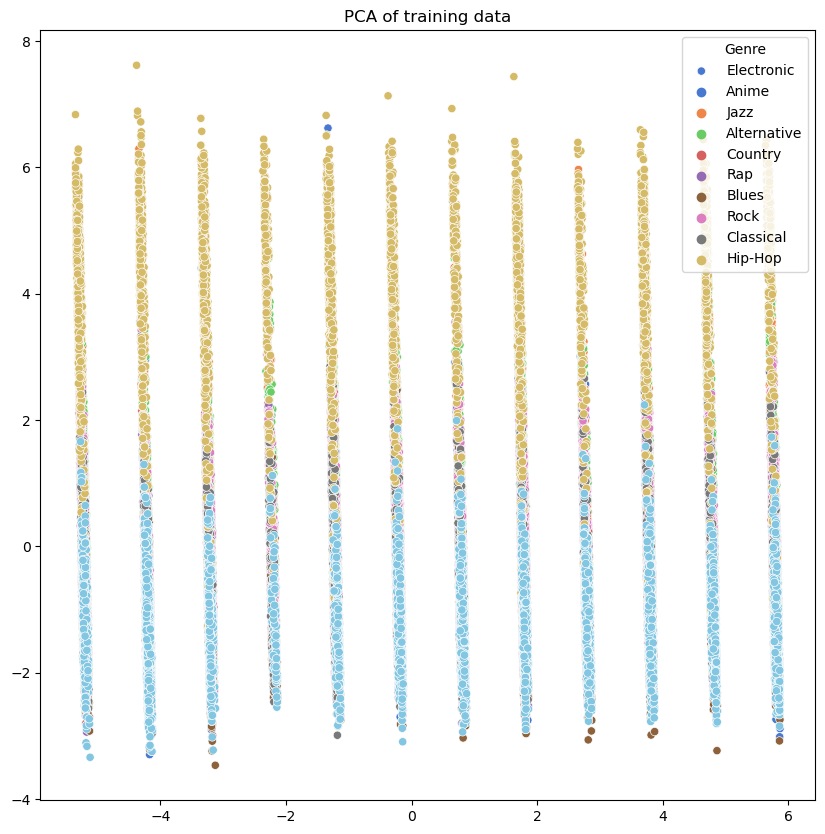

In [258]:
from sklearn.decomposition import PCA

pca = PCA()
data_pca = pca.fit_transform(X_train)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=y_train, palette='muted')

plt.legend(title='Genre', loc='upper right', labels=[genre for genre in genre_map])
plt.title('PCA of training data')
plt.show()



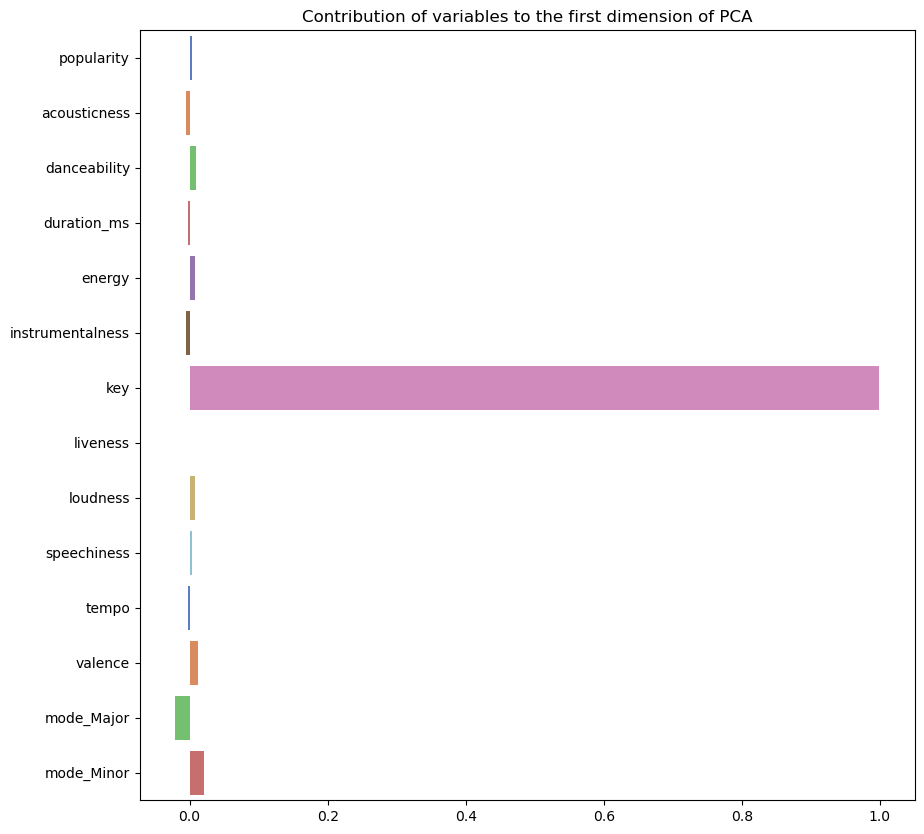

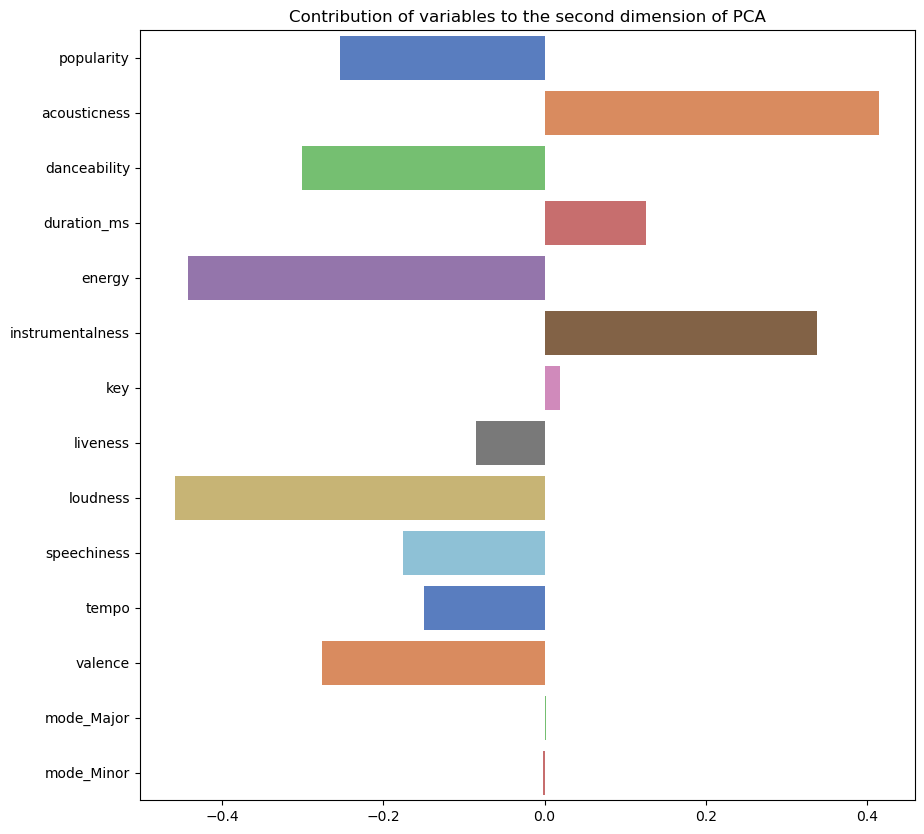

In [257]:
# CHECK HOW MUCH EACH VARIABLE CONTRIBUTE TO THE FIRST 2 DIMS OF PCA
pca.components_[:2]

# plot the contribution of each variable to the first 2 dims of PCA
plt.figure(figsize=(10, 10))
sns.barplot(x=pca.components_[0], y=X_train.columns, palette='muted')
plt.title('Contribution of variables to the first dimension of PCA')
plt.show()

plt.figure(figsize=(10, 10))
sns.barplot(x=pca.components_[1], y=X_train.columns, palette='muted')
plt.title('Contribution of variables to the second dimension of PCA')
plt.show()


Graphing the first 2 dimensions of PCA show 12 distinct, slightly slanted vertical patterns. These 2 dimensions explain 67.9% of the variance.

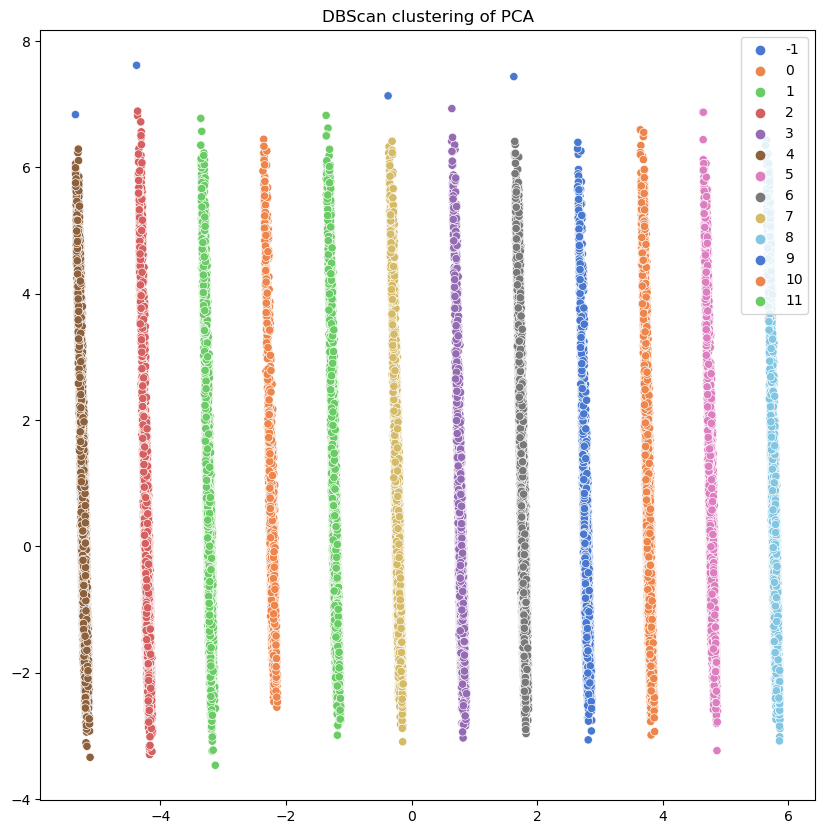

In [63]:
# cluster PCA with DBScan

from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data_pca[:,0:2])

plt.figure(figsize=(10, 10))
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=clusters, palette='muted')
plt.title('DBScan clustering of PCA')
plt.show()







## 6. Classification Models


### Logistic Regression

- With train data with fulll dimensions

In [267]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score


log_reg = LogisticRegression(max_iter=1000, multi_class='ovr')

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)

lr_accuracy = log_reg.score(X_test, y_test)
print('Accuracy:', lr_accuracy)

auroc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print('AUROC:', auroc)




Accuracy: 0.515
AUROC: 0.8911246666666667


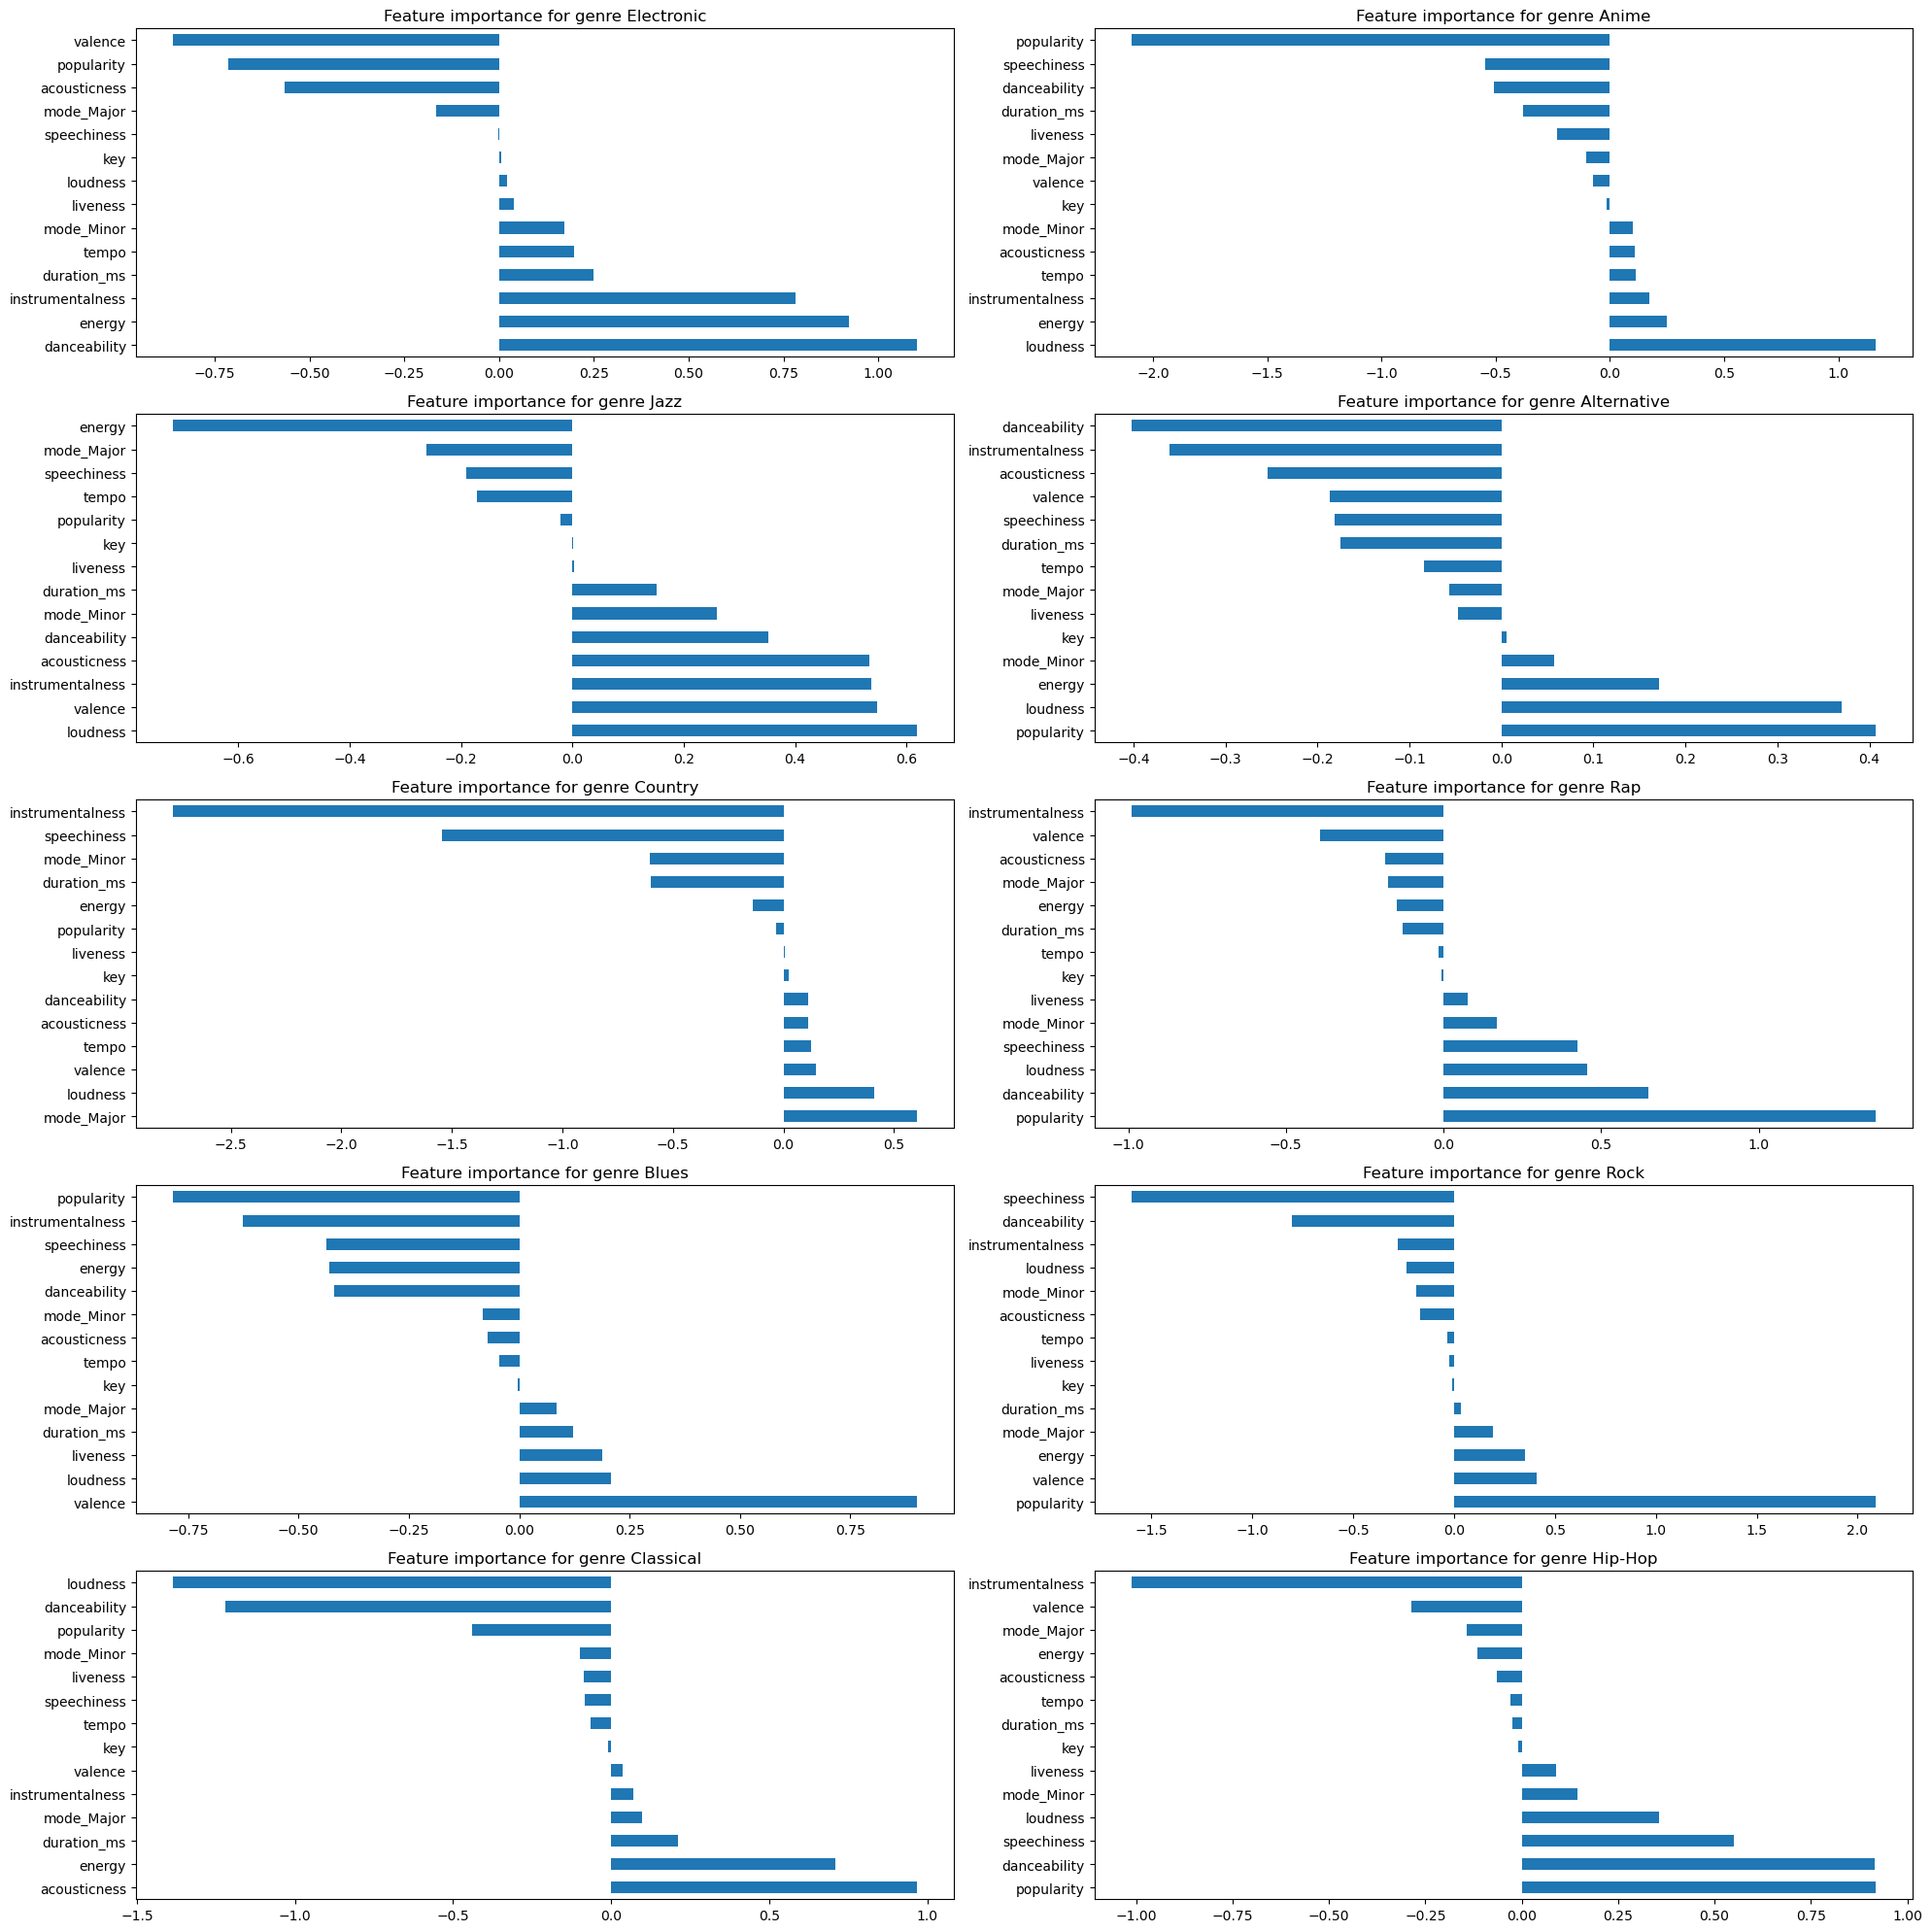

In [268]:
# for each genre - rank the absolute val coeffs of features
genre_importance = {}
features = X_train.columns

for genre in range(10):
    coefs = log_reg.coef_[genre]
    importance = pd.Series(coefs, index=features)
    importance = importance.sort_values(ascending=False)
    genre_importance[genre] = importance

# plot importance of features for each genre
fig = plt.figure(figsize=(20, 20))
for genre in range(10):
    fig.add_subplot(5, 2, genre+1)
    genre_importance[genre].plot(kind='barh')
    # map genre to genre name
    plt.title(f'Feature importance for genre {list(genre_map.keys())[list(genre_map.values()).index(genre)]}')
plt.tight_layout()
plt.show()



- With LDA dimensionality reduced training data

In [130]:
log_reg_lda = LogisticRegression(max_iter=1000, multi_class='ovr')
log_reg_lda.fit(data_lda, y_train)
test_lda = lda.transform(X_test)
y_pred_lda = log_reg_lda.predict(test_lda)
accuracy_lda = log_reg_lda.score(test_lda, y_test)
print('Accuracy:', accuracy_lda)

auroc_lda = roc_auc_score(y_test, log_reg_lda.predict_proba(test_lda), multi_class='ovr')
print('AUROC:', auroc_lda)


Accuracy: 0.5146
AUROC: 0.8900828888888889


- With PCA data

In [129]:
log_reg_pca = LogisticRegression(max_iter=1000, multi_class='ovr')
log_reg_pca.fit(data_pca, y_train)
test_pca = pca.transform(X_test)
y_pred_pca = log_reg_pca.predict(test_pca)
accuracy_pca = log_reg_pca.score(test_pca, y_test)
print('Accuracy:', accuracy_pca)

auroc_pca = roc_auc_score(y_test, log_reg_pca.predict_proba(test_pca), multi_class='ovr')
print('AUROC:', auroc_pca)

Accuracy: 0.515
AUROC: 0.8911256


### - Random Forest

Random Forest with training data to confirm feature importance in genre classifcation

Accuracy: 0.572
AUROC: 0.9274242444444443


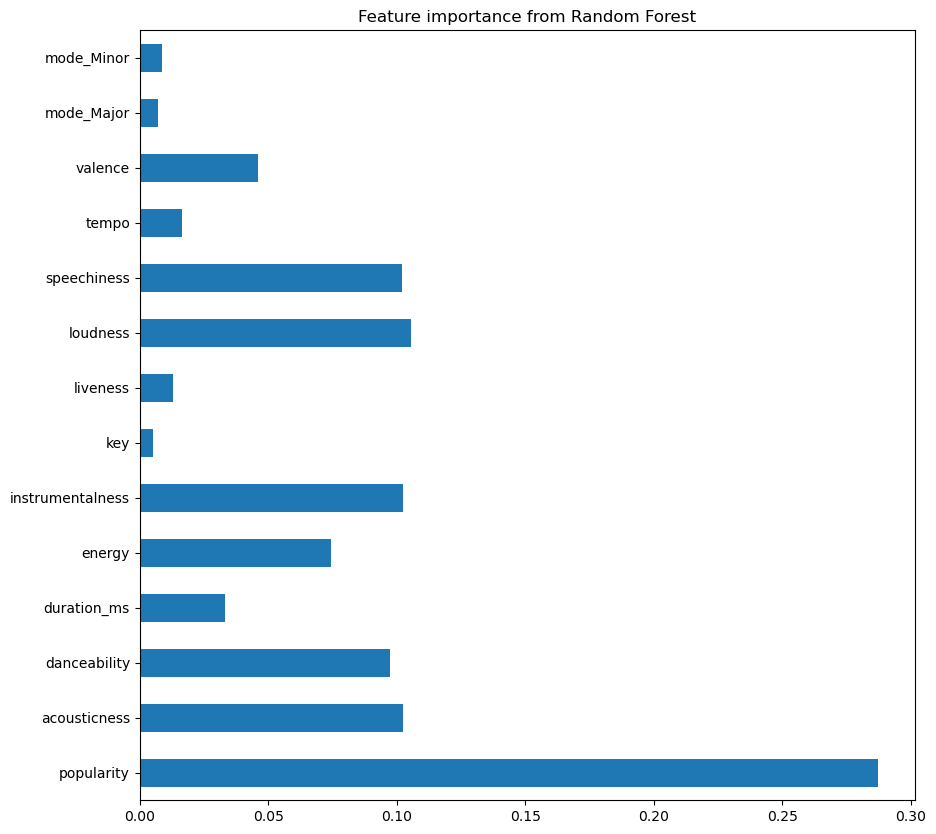

In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Accuracy:', accuracy_rf)

auroc_rf = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')
print('AUROC:', auroc_rf)

# feature importance from random forest
importance_rf = rf.feature_importances_
importance_rf = pd.Series(importance_rf, index=X_train.columns)

plt.figure(figsize=(10, 10))
importance_rf.plot(kind='barh')
plt.title('Feature importance from Random Forest')
plt.show()


I also built RandomForestClassifier using dimensionality reduced data from PCA and LDA to compare the with the model using all dimensions of the training data.

In [134]:
# rf with PCA data
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(data_pca, y_train)

y_pred = rf.predict(test_pca)
y_pred_proba = rf.predict_proba(test_pca)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
print('ROC AUC:', roc_auc)

Accuracy: 0.5268
ROC AUC: 0.9073904888888888


In [135]:
# rf with LDA data
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(data_lda, y_train)


y_pred = rf.predict(test_lda)

y_pred_proba = rf.predict_proba(test_lda)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
print('ROC AUC:', roc_auc)


Accuracy: 0.5502
ROC AUC: 0.9181331111111113


### XGBoost
- With training set

In [137]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators=100, objective='multi:softmax')
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba,  multi_class='ovr')

print('ROC AUC:', roc_auc)


Accuracy: 0.5692
ROC AUC: 0.9320137333333334


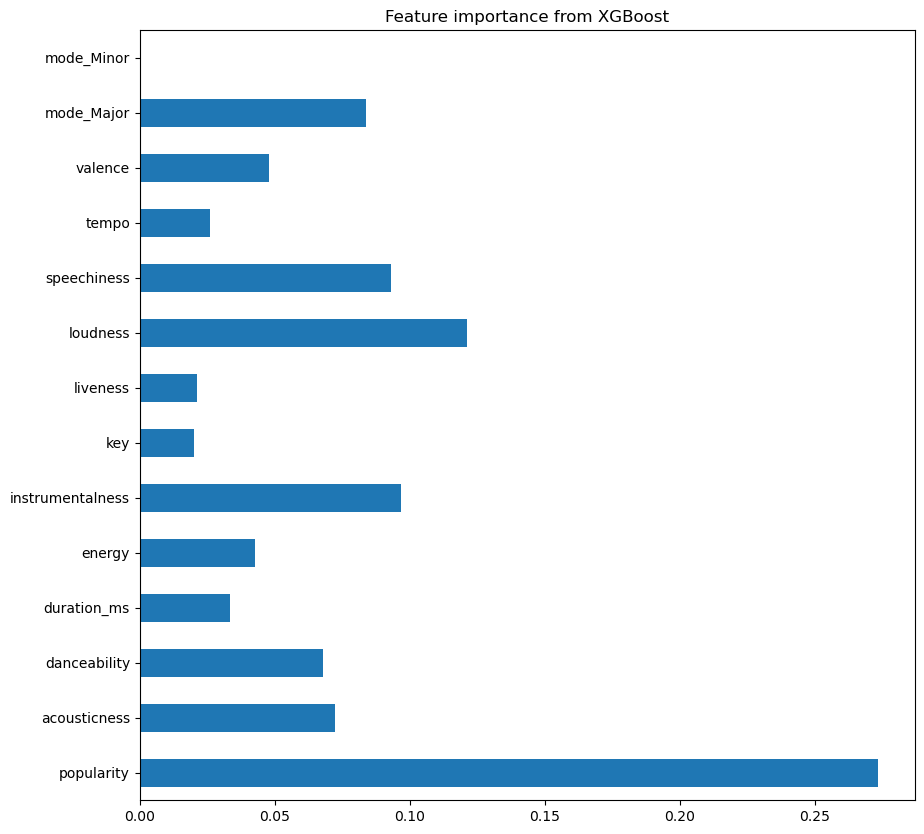

In [138]:
#feature importance from xgboost
importance_xgb = xgb_clf.feature_importances_
importance_xgb = pd.Series(importance_xgb, index=X_train.columns)

plt.figure(figsize=(10, 10))
importance_xgb.plot(kind='barh')
plt.title('Feature importance from XGBoost')
plt.show()


- With LDA and PCA data

In [140]:
xgb_clf.fit(data_lda, y_train)
y_pred = xgb_clf.predict(test_lda)
y_pred_proba = xgb_clf.predict_proba(test_lda)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba,  multi_class='ovr')

print('ROC AUC:', roc_auc)

Accuracy: 0.543
ROC AUC: 0.9193047555555556


In [139]:
xgb_clf.fit(data_pca, y_train)
y_pred = xgb_clf.predict(test_pca)
y_pred_proba = xgb_clf.predict_proba(test_pca)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba,  multi_class='ovr')

print('ROC AUC:', roc_auc)

Accuracy: 0.5348
ROC AUC: 0.912773111111111


Observations:
- Tree based models perform the best on training data before dimensionality reduction, followed by LDA, and PCA ranks last
- 'Popularity' is the most important feature in logistic regression and tree-based methods.

## Neural Networks
- Trained with original training set

In [25]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=SEED)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

y_pred_proba = mlp.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
print('ROC AUC:', roc_auc)


Accuracy: 0.5596
ROC AUC: 0.9233765333333335


In [228]:
# lda 
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=SEED)
mlp.fit(data_lda, y_train)
y_pred = mlp.predict(test_lda)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

y_pred_proba = mlp.predict_proba(test_lda)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
print('ROC AUC:', roc_auc)


Accuracy: 0.5504
ROC AUC: 0.9188758666666664


In [229]:
# pca 
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=SEED)
mlp.fit(data_pca, y_train)
y_pred = mlp.predict(test_pca)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

y_pred_proba = mlp.predict_proba(test_pca)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
print('ROC AUC:', roc_auc)

Accuracy: 0.5578
ROC AUC: 0.9199809777777777


    - Hyperparameter tunning 

- Hyperparameter tuning with custom ROC_AUC scorer, training data as the input

In [141]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RandomizedSearchCV

def roc_auc_score_multiclass(y_true, y_pred):
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    roc_auc = roc_auc_score(y_true_bin, y_pred, average='weighted', multi_class='ovr')
    return roc_auc

roc_auc_scorer = make_scorer(roc_auc_score_multiclass, needs_proba=True, greater_is_better=True)

param_grid = {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)],
                'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'learning_rate': ['constant', 'invscaling', 'adaptive']}
mlp = MLPClassifier(max_iter=1000, random_state=SEED)
random_search = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=10, cv=3,scoring=roc_auc_scorer, random_state=SEED)
random_search.fit(X_train, y_train)
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


y_pred_proba = random_search.predict_proba(test_lda)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
print('ROC AUC:', roc_auc)

{'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100), 'alpha': 1}
0.92344670781893
MLPClassifier(alpha=1, hidden_layer_sizes=(100, 100),
              learning_rate='invscaling', max_iter=1000)
Accuracy: 0.5736
ROC AUC: 0.9279124


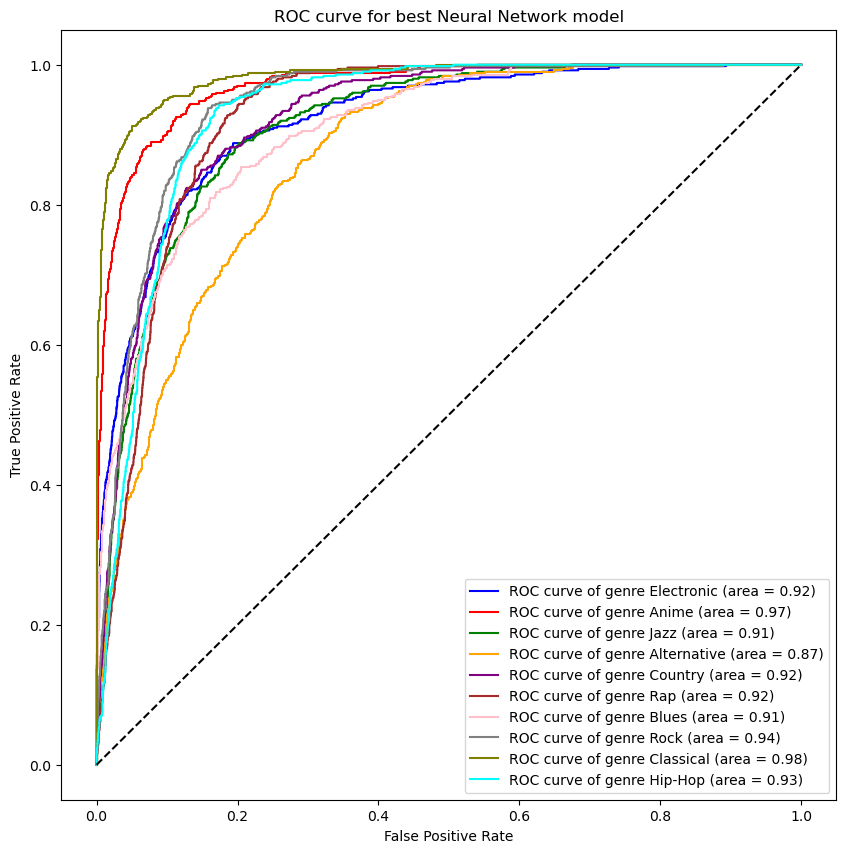

In [142]:
# graph ROC curve

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def graph_roc(self):
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    y_pred_proba = random_search.predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 10))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i in range(10):
        genre_name = [genre for genre in genre_map if genre_map[genre] == i][0]
        plt.plot(fpr[i], tpr[i], color=colors[i], label='Genre {0} (AUC = {1:0.2f})'.format(genre_name, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for best Neural Network model')
    plt.legend(loc='lower right')
    plt.show()




- Hyperparameter tune with LDA training data, AUROC scorer

In [144]:
random_search = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=10, cv=3,scoring=roc_auc_scorer, random_state=SEED)
random_search.fit(data_lda, y_train)
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
y_pred = random_search.predict(test_lda)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

y_pred_proba = random_search.predict_proba(test_lda)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
print('ROC AUC:', roc_auc)

{'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.01}
0.9256592855967077
MLPClassifier(alpha=0.01, max_iter=1000)
Accuracy: 0.5768
ROC AUC: 0.9293468


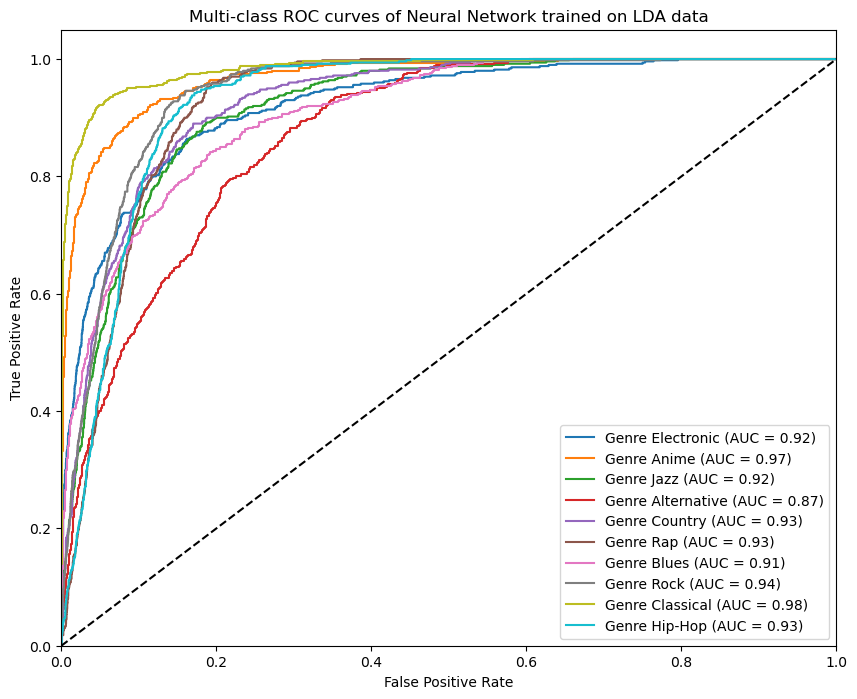

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # num_classes is the number of classes in your data
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])




# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    genre_name = [genre for genre in genre_map if genre_map[genre] == i][0]
    plt.plot(fpr[i], tpr[i], label=f'Genre {genre_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curves of Neural Network trained on LDA data')
plt.legend(loc="lower right")
plt.show()
